# **Carga y Exploración de Datos**


## **Objetivo** 

Comprender la estructura, distribución y relaciones en el dataset mediante:

- Análisis estadístico descriptivo

- Visualización de distribuciones

- Identificación de patrones iniciales

## **Dataset**

El conjunto de datos proviene del UCI Machine Learning Repository y contiene información sobre:

- Características demográficas

- Historial académico previo

- Desempeño durante el semestre

- Resultados finales (abandono y calificaciones)

## **Librerías**

In [1]:
# Importación de librerías (celda de código)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, 
                           roc_auc_score, confusion_matrix, classification_report,
                           mean_absolute_error, mean_squared_error, r2_score)
from sklearn.metrics import roc_curve, auc

## **Importación de los datos**

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
predict_students_dropout_and_academic_success = fetch_ucirepo(id=697) 
  
# data (as pandas dataframes) 
X = predict_students_dropout_and_academic_success.data.features 
y = predict_students_dropout_and_academic_success.data.targets 
  
# metadata 
print(predict_students_dropout_and_academic_success.metadata) 
  
# variable information 
print(predict_students_dropout_and_academic_success.variables) 


{'uci_id': 697, 'name': "Predict Students' Dropout and Academic Success", 'repository_url': 'https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success', 'data_url': 'https://archive.ics.uci.edu/static/public/697/data.csv', 'abstract': "A dataset created from a higher education institution (acquired from several disjoint databases) related to students enrolled in different undergraduate degrees, such as agronomy, design, education, nursing, journalism, management, social service, and technologies.\nThe dataset includes information known at the time of student enrollment (academic path, demographics, and social-economic factors) and the students' academic performance at the end of the first and second semesters. \nThe data is used to build classification models to predict students' dropout and academic sucess. The problem is formulated as a three category classification task, in which there is a strong imbalance towards one of the classes.", 'area': 'Social Sc

## **Análisis Exploratorio de los datos (EDA)**

### **Análisis Inicial**

In [3]:
# Carga de datos
data = fetch_ucirepo(id=697)
df = pd.concat([data.data.features, data.data.targets], axis=1)

# 1.1. Análisis inicial
print("Información básica:")
print(f"- Dimensiones: {df.shape}")
print(f"- Variables: {len(df.columns)}")
print(f"- Valores faltantes: {df.isnull().sum().sum()}")

Información básica:
- Dimensiones: (4424, 37)
- Variables: 37
- Valores faltantes: 0


### **Estadísticos Descriptivos**

In [4]:
print("\nEstadísticas descriptivas:")
display(df.describe(include='all'))


Estadísticas descriptivas:


,Marital Status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,...,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Graduate
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2209
mean,1.178571,18.669078,1.727848,8856.642631,0.890823,4.577758,132.613314,1.873192,19.561935,22.275316,...,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969,NaN
std,0.605747,17.484682,1.313793,2063.566416,0.311897,10.216592,13.188332,6.914514,15.603186,15.343108,...,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935,NaN
min,1.000000,1.000000,0.000000,33.000000,0.000000,1.000000,95.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000,NaN
25%,1.000000,1.000000,1.000000,9085.000000,1.000000,1.000000,125.000000,1.000000,2.000000,3.000000,...,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000,NaN
50%,1.000000,17.000000,1.000000,9238.000000,1.000000,1.000000,133.100000,1.000000,19.000000,19.000000,...,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000,NaN
75%,1.000000,39.000000,2.000000,9556.000000,1.000000,1.000000,140.000000,1.000000,37.000000,37.000000,...,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000,NaN


### **Distribución de Variable Objetivo (Clasificación)**

Text(0.5, 1.0, 'Distribución de Abandono')

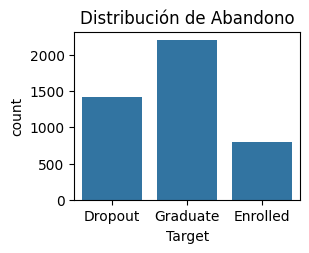

In [5]:
plt.subplot(2, 2, 1)
sns.countplot(data=df, x='Target')
plt.title('Distribución de Abandono')

## **Boxplots**

ValueError: Could not interpret value `Average_grade` for `y`. An entry with this name does not appear in `data`.

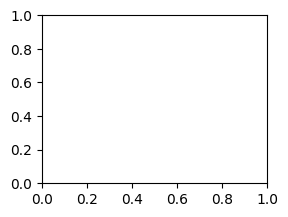

In [6]:
plt.subplot(2, 2, 4)
sns.boxplot(data=df, x='Target', y='Average_grade')
plt.title('Distribución de Promedios por Estado de Abandono')
plt.xlabel('Estado del Estudiante')
plt.ylabel('Promedio Académico')

plt.tight_layout()
plt.show()

### **Distribución del promedio** 

In [11]:
# Crear nueva columna con el promedio de ambos semestres
df['Average_grade'] = (df['Curricular units 1st sem (grade)'] + df['Curricular units 2nd sem (grade)']) / 2

# Verificar cálculo
print("Estadísticas del promedio académico:")
print(df['Average_grade'].describe())

Estadísticas del promedio académico:
count    4424.000000
mean       10.435514
std         4.818530
min         0.000000
25%        11.000000
50%        12.250000
75%        13.266667
max        18.283654
Name: Average_grade, dtype: float64


Text(0, 0.5, 'Frecuencia')

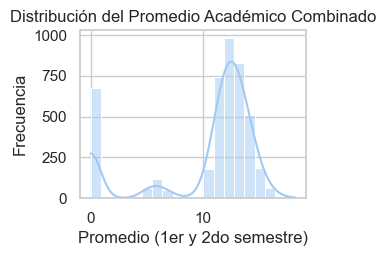

In [12]:
plt.subplot(2, 2, 2)
sns.histplot(data=df, x='Average_grade', bins=20, kde=True)
plt.title('Distribución del Promedio Académico Combinado')
plt.xlabel('Promedio (1er y 2do semestre)')
plt.ylabel('Frecuencia')

#### **Distribución por semestre**

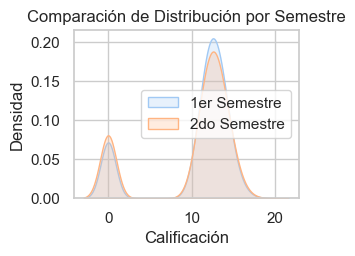

In [13]:
plt.subplot(2, 2, 3)
sns.kdeplot(data=df, x='Curricular units 1st sem (grade)', label='1er Semestre', fill=True)
sns.kdeplot(data=df, x='Curricular units 2nd sem (grade)', label='2do Semestre', fill=True)
plt.title('Comparación de Distribución por Semestre')
plt.xlabel('Calificación')
plt.ylabel('Densidad')
plt.legend()